In [0]:
from google.colab import drive
drive.mount('/drive')


In [0]:
import json
with open("/drive/My Drive/data/kaggle.json", "r") as f:
  data = json.loads(f.read())

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = data['username'] # username from the json file
os.environ['KAGGLE_KEY'] = data['key'] # key from the json file
!kaggle competitions download -c Kannada-MNIST # api copied from kaggle

  0% 0.00/818k [00:00<?, ?B/s]
100% 818k/818k [00:00<00:00, 53.9MB/s]
  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 129MB/s]
 52% 5.00M/9.71M [00:00<00:00, 41.9MB/s]
100% 9.71M/9.71M [00:00<00:00, 61.7MB/s]
  0% 0.00/33.1k [00:00<?, ?B/s]
100% 33.1k/33.1k [00:00<00:00, 35.2MB/s]


In [4]:
!unzip Dig-MNIST.csv.zip
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  Dig-MNIST.csv.zip
  inflating: Dig-MNIST.csv           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
import pandas as pd
import numpy as np


In [0]:
data = pd.read_csv("Dig-MNIST.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [7]:
test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
train.groupby("label").size()


label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

# Our classes are balanced

Text(0, 0.5, 'Classes')

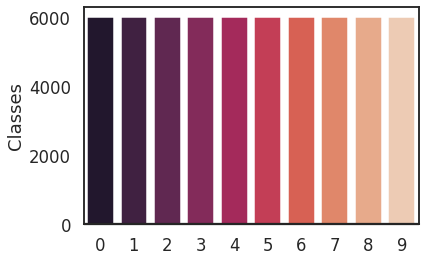

In [10]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

sns.barplot(x=train["label"].unique().tolist(), y=train.groupby("label").size().tolist(), palette="rocket")
plt.axhline(0, color="k", clip_on=False)
plt.ylabel("Classes")

In [11]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### The size of the picture will be 28*28



In [0]:
import math 
math.sqrt(784)

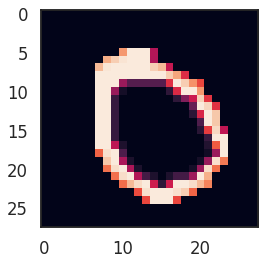

In [13]:
first_row = data.loc[0, data.columns != 'label']
img = first_row.to_numpy()
plt.imshow(img.reshape(28,28))

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
from time import sleep

batch_size=120
INPUT_SIZE=28
hidden_size = 128
nb_class = len(list(train.groupby("label").size()))

In [0]:
y_true = train["label"]
y_true.shape


In [0]:
X_train = train.drop(columns="label")
X_train.shape


In [0]:
from sklearn.model_selection import train_test_split
#@markdown  ###Use cross validation to validate our model

In [0]:
X_train_, X_val,  y_train_, y_val = train_test_split(X_train, y_true, test_size=0.30, random_state = 42)

In [0]:
class RNN(nn.Module):

  def __init__(self, INPUT_SIZE, hidden_size, nb_class):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=hidden_size           # number of rnn layer
            )
    self.out = nn.Linear(hidden_size, nb_class)
  def forward(self, x):
    # Set initial hidden and cell states 
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    c0 = torch.zeros(1, x.size(0), self.hidden_size)
    
    # Forward propagate LSTM
    output, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    outputs = self.out(output[:, -1, :])
    return outputs

    
    

In [0]:
rnn = RNN(INPUT_SIZE, hidden_size, nb_class)

In [0]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


In [0]:
def train( X, y_train, epochs, batch_size):
  
  for epoch in range(epochs):
    cache = 0

    for batch in range(batch_size,len(X), batch_size) :

      X_cache = X
      X_reshape = X_cache[cache:batch].values
      X_reset = torch.Tensor(X_reshape.reshape(batch_size,INPUT_SIZE,INPUT_SIZE))
      cache = batch
      output_val = rnn(X_reset)

      label = list(y_train[cache:(batch_size+batch)])
      label_y = [int(i) for i in label]
      label = np.array([int(i) for i in label_y]) 
      loss = criterion(output_val.squeeze(), torch.LongTensor(label_y))

      optimizer.zero_grad()                           
      loss.backward()                                 
      optimizer.step()                                

      sys.stdout.write('\r')
      sys.stdout.write(" Train data epoch %d [%-100s] %d/%d \t Loss:%f" % (epoch , '='*int((batch/len(X))*100), batch, len(X), loss.item()))
      sys.stdout.flush()
      sleep(0.25)
      if batch == len(X)/2:
        test_output = rnn(X_reset)  
        pred_y = torch.max(test_output, 1)[1].data.numpy()
        accuracy = float((pred_y == label).astype(int).sum()) / float(label.size)
        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % (1-accuracy))


    if epoch %100 == 0:
      pred_y = rnn(X_reset)
      print("\n")
      print('Epoch {}, loss {}'.format(epoch, loss.item()))
      #print('Epoch {}, accuracy {}'.format(epoch, accuracy.item()))

train(X_train_, y_train_, epochs=1000, batch_size=28)

 Train data epoch 0 [==================================================                                                  ] 21000/42000 	 Loss:2.290966Epoch:  0 | train loss: 2.2910 | test accuracy: 0.89
 Train data epoch 0 [=================================================================================================== ] 41972/42000 	 Loss:2.304004

Epoch 0, loss 2.304003953933716
 Train data epoch 1 [==============================================                                                      ] 19628/42000 	 Loss:2.306040

In [0]:
!git add test.csv train.csv Dig-MNIST.csv

In [0]:
!git add "./drive/My Drive/MNIST_kaggle.ipynb"

In [0]:
!git commit -m "add RNN class and first reshape"

In [0]:
!git config --global user.email ""
!git config --global user.name ""

In [0]:
!git push origin master

In [0]:
!ls git

In [0]:
!ls -la ./MNIST_pytorch

In [0]:
!cp -r ./MNIST_pytorch/.git ./